## Random Forest Classifier: make predictions for all paralog pairs

**Input**:
* All features for all paralog pairs
* Data sets of (non-)SL paralog pairs from combinatorial screens
* Random Forest Classifier (pickle)

**Output**:
* Predictions for all paralog pairs (>=20% sequence identity)
* Table S8: Feature values and predictions for all paralog pairs

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.ensemble import RandomForestClassifier
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

import graphing_params as gp
%load_ext autoreload
%autoreload 1
%aimport graphing_params

import itertools
import os

get_local_data_path = lambda folders, fname: os.path.normpath('../local_data/' +'/'.join(folders) +'/'+ fname)

# Inputs
file_feature_list = get_local_data_path([],'feature_list.txt')
file_annot_pairs = get_local_data_path(['processed','paralog_features'], 'all_features.csv')
file_RF_model = get_local_data_path(['results'], 'RF_model.pickle')

file_thompson_pairs = get_local_data_path(['processed', 'screen_pairs'], 'thompson_pairs.csv')
file_dede_pairs = get_local_data_path(['processed', 'screen_pairs'], 'dede_pairs.csv')
file_chymera_pairs = get_local_data_path(['processed','screen_pairs'], 'chymera_pairs_filtered.csv')
file_parrish_pairs = get_local_data_path(['processed','screen_pairs'], 'parrish_pairs.csv')
file_all_screened_pairs = get_local_data_path(['processed', 'screen_pairs'], 'all_screened_pairs.csv')
file_consensus_pairs = get_local_data_path(['processed', 'screen_pairs'], 'consensus_pairs.csv')

# To annotate the predictions
file_depmap_pairs = get_local_data_path(['results'], 'depmap_pairs.csv')
file_validated_SLs = get_local_data_path([], 'validated_SLs.txt')

# Outputs
file_all_predictions = get_local_data_path(['results'], 'all_predictions.csv')
file_table_s8 = get_local_data_path(['supplemental_files'], 'Table_S8.csv')

### Load Data

#### All paralog pairs with feature annotations

In [2]:
all_paralog_annotations = pd.read_csv(file_annot_pairs, float_precision="round_trip")
print('Num annotated paralog pairs:', all_paralog_annotations.shape[0])
all_paralog_annotations[:1]

Num annotated paralog pairs: 36648


,sorted_gene_pair,A1,A2,A1_ensembl,A2_ensembl,A1_entrez,A2_entrez,closest,min_sequence_identity,max_sequence_identity,...,has_essential_pombe_ortholog,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val
0,A1BG_OSCAR,A1BG,OSCAR,ENSG00000121410,ENSG00000170909,1,126014,False,0.127273,0.22028,...,False,False,False,False,3,210.95,0.0,False,False,False


In [3]:
features = pd.read_csv(file_feature_list).feature.values
print('N features', len(features))

N features 22


#### Results from combinatorial screens

In [4]:
all_thompson_pairs = pd.read_csv(file_thompson_pairs)
all_thompson_pairs = all_thompson_pairs[all_thompson_pairs.passes_min_1_filter]
all_thompson_pairs = pd.merge(all_thompson_pairs, all_paralog_annotations)
print('All:', sum(all_thompson_pairs.n_SL>0), '/', all_thompson_pairs.shape[0])

All: 71 / 475


In [5]:
all_dede_pairs = pd.read_csv(file_dede_pairs)
all_dede_pairs = pd.merge(all_dede_pairs, all_paralog_annotations)
print('All:', sum(all_dede_pairs.n_SL>0), '/', all_dede_pairs.shape[0])

All: 24 / 393


In [6]:
all_parrish_pairs = pd.read_csv(file_parrish_pairs)
all_parrish_pairs = pd.merge(all_parrish_pairs, all_paralog_annotations)
print('All:', sum(all_parrish_pairs.n_SL>0), '/', all_parrish_pairs.shape[0])

All: 122 / 1027


In [7]:
all_chymera_pairs = pd.read_csv(file_chymera_pairs)
all_chymera_pairs = pd.merge(all_chymera_pairs, all_paralog_annotations)
print('All:', sum(all_chymera_pairs.n_SL>0), '/', all_chymera_pairs.shape[0])

All: 72 / 658


#### Consensus pairs
TPs = Paralog pairs found to be hits in at least two studies (Dede/Thompson/Parrish/Chymera)  
TNs = Pairs screened in at least two studies and not found to be hits in any study

In [8]:
all_screened_pairs = pd.read_csv(file_all_screened_pairs)
print('N=', all_screened_pairs.shape[0])
display(all_screened_pairs[:1])
all_screened_pairs = pd.merge(all_screened_pairs, all_paralog_annotations)

N= 1845


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0


In [9]:
consensus_pairs = pd.read_csv(file_consensus_pairs)
print('N=', consensus_pairs.shape[0])
consensus_pairs[:1]

N= 457


,sorted_gene_pair,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,SL
0,CASKIN1_CASKIN2,0.0,NaN,NaN,0.0,2,0,False


### Classifier

In [10]:
# Load RF classifier from file
with open(file_RF_model, 'rb') as f:
    RF = pickle.load(f)

### Predictions for all sets of screened pairs

In [11]:
thompson_predictions = all_thompson_pairs.assign(SL_pred=RF.predict_proba(all_thompson_pairs[features])[:,1])
dede_predictions = all_dede_pairs.assign(SL_pred=RF.predict_proba(all_dede_pairs[features])[:,1])
parrish_predictions = all_parrish_pairs.assign(SL_pred=RF.predict_proba(all_parrish_pairs[features])[:,1])
chymera_predictions = all_chymera_pairs.assign(SL_pred=RF.predict_proba(all_chymera_pairs[features])[:,1])

In [12]:
blue_palette = sns.color_palette("Blues", n_colors=4)
def draw_stripplot_w_medians(predictions, ax, screen_name, ylab='', two_plus=False):
    if two_plus:
        predictions['n_SL'] = predictions.n_SL.apply(lambda x: x if x<=2 else 2)
    sns.stripplot(y='SL_pred', x='n_SL', data=predictions, palette=blue_palette, ax=ax, alpha=0.9, size=4, zorder=0, jitter=0.1)
    for idx, (tick, text) in enumerate(zip(ax.get_xticks(), ax.get_xticklabels())):
        n = text.get_text()
        median_val = predictions[predictions['n_SL']==int(n)].SL_pred.median()
        median_width = 0.8
        ax.plot([tick-median_width/2, tick+median_width/2], [median_val, median_val], lw=1.2, color='black')
    gp.set_axis_props(ax, xlabel='N. cell lines in which\npair is a hit', ylabel=ylab, 
                      show_yticks=(False if ylab=='' else True))
    ax.set_title(screen_name, fontsize=9.5)

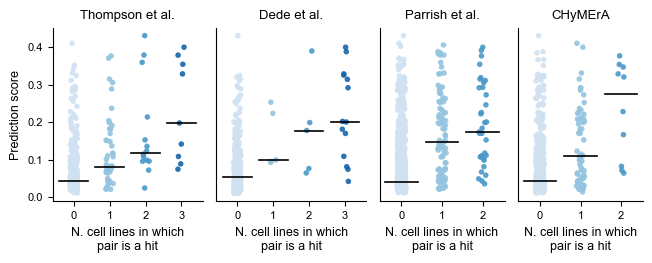

In [13]:
f, ax = plt.subplots(1, 4, figsize=(6.6,2.7), gridspec_kw={'width_ratios':[1.2, 1.2, 1, 1]}, sharey=True)
draw_stripplot_w_medians(thompson_predictions, ax[0], 'Thompson et al.', ylab='Prediction score')
draw_stripplot_w_medians(dede_predictions, ax[1], 'Dede et al.')
draw_stripplot_w_medians(parrish_predictions, ax[2], 'Parrish et al.')
draw_stripplot_w_medians(chymera_predictions, ax[3], 'CHyMErA')
plt.tight_layout()
f.savefig("../figures/for_paper/screen_prediction_stripplots.svg", bbox_inches="tight", dpi=300)

In [14]:
for screen in [thompson_predictions, dede_predictions, parrish_predictions, chymera_predictions]:
    print('1 v 2+ Mann-U', 'stat=%.1f, pval=%.4f' % 
          (stats.mannwhitneyu(screen[screen.n_SL==1].SL_pred, screen[screen.n_SL>1].SL_pred, alternative='two-sided')))

1 v 2+ Mann-U stat=323.0, pval=0.0050
1 v 2+ Mann-U stat=39.0, pval=0.5696
1 v 2+ Mann-U stat=1288.0, pval=0.1853
1 v 2+ Mann-U stat=168.0, pval=0.0212


In [15]:
for screen in [thompson_predictions, dede_predictions, parrish_predictions, chymera_predictions]:
    print('0 v 1 Mann-U', 'stat=%.1f, pval=%e' % 
          (stats.mannwhitneyu(screen[screen.n_SL==0].SL_pred, screen[screen.n_SL==1].SL_pred, alternative='two-sided')))

0 v 1 Mann-U stat=5382.0, pval=4.618898e-07
0 v 1 Mann-U stat=297.0, pval=9.243998e-03
0 v 1 Mann-U stat=17997.0, pval=5.658003e-17
0 v 1 Mann-U stat=10324.0, pval=2.218919e-08


### Predictions for all ~36.6k paralog pairs

In [17]:
ypred = RF.predict_proba(all_paralog_annotations[features])[:,1]
all_predictions = all_paralog_annotations[['sorted_gene_pair','A1','A2','A1_entrez','A2_entrez','A1_ensembl','A2_ensembl']]
all_predictions = all_predictions.assign(prediction_score=ypred)
all_predictions = all_predictions.sort_values('prediction_score', ascending=False)

print('Mean prediction: %.4f, median: %.4f' % (all_predictions.prediction_score.mean(), 
                                               all_predictions.prediction_score.median()))

# Annotate the predictions dataframe: note for each pair whether it was a previously validated SL 
validated_SLs = pd.read_csv(file_validated_SLs)
all_predictions = pd.merge(all_predictions, validated_SLs, how='left', indicator='validated_SL')
all_predictions['validated_SL'] = all_predictions['validated_SL'] == 'both'
assert(all_predictions[all_predictions.validated_SL==True].shape[0] == 12)

# Also note num screens in which it was SL and num screens in which it was included
all_predictions = pd.merge(all_predictions, all_screened_pairs, how='left')
all_predictions = all_predictions.fillna({'n_screens':0,'n_screens_SL':0}).astype({'n_screens':'int','n_screens_SL':'int'})

# And whether it was a Broad DepMap hit
depmap_pairs = pd.read_csv(file_depmap_pairs)
all_predictions = pd.merge(all_predictions, depmap_pairs.rename(columns={'SL':'depmap_hit'}), how='left')

# Add column for prediction rank
all_predictions = all_predictions.reset_index().rename(columns={'index':'prediction_rank'})
all_predictions['prediction_rank'] = all_predictions['prediction_rank']+1
assert(all_predictions.prediction_rank.max()==all_predictions.shape[0])

# Add percentile of rank
def round_up_to(num, decimals=1):
    factor = 10 ** decimals
    return math.ceil(num * factor) / factor

all_predictions.insert(1, 'prediction_percentile', all_predictions.prediction_rank.rank(pct=True)*100)
all_predictions.prediction_percentile = all_predictions.prediction_percentile.apply(lambda x: round_up_to(x))

all_predictions[:2]

Mean prediction: 0.0278, median: 0.0202


,prediction_rank,prediction_percentile,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,prediction_score,...,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val,depmap_hit
0,1,0.1,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,0.430886,...,True,False,False,8.0,1368.0,0.333333,True,True,False,True
1,2,0.1,EXOC6_EXOC6B,EXOC6,EXOC6B,54536,23233,ENSG00000138190,ENSG00000144036,0.410447,...,True,True,False,8.0,1628.0,0.250000,True,True,False,True


In [19]:
# Save predictions
all_predictions.to_csv(file_all_predictions, index=0)

In [20]:
# Table S8: all predictions and all feature values
tab_s8 = pd.merge(all_predictions.drop(columns=['n_SL_thompson','n_SL_dede','n_SL_parrish','n_SL_chymera']), 
                  all_paralog_annotations[['sorted_gene_pair']+list(features)+['has_imputed_val']])
display(tab_s8[:2])
tab_s8.to_csv(file_table_s8, index=0)

,prediction_rank,prediction_percentile,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,prediction_score,...,has_pombe_ortholog_ip,has_single_essential_pombe_ortholog,has_ecoli_ortholog,conservation_score,mean_age,colocalisation,same_subcell_loc,both_have_loc,has_imputed_val,depmap_hit
0,1,0.1,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,0.430886,...,True,False,False,8.0,1368.0,0.333333,True,True,False,True
1,2,0.1,EXOC6_EXOC6B,EXOC6,EXOC6B,54536,23233,ENSG00000138190,ENSG00000144036,0.410447,...,True,True,False,8.0,1628.0,0.250000,True,True,False,True


### 'Waterfall' plot of all predictions

In [129]:
# Can load predictions here
all_predictions = pd.read_csv(file_all_predictions)
all_predictions[:1]

,prediction_rank,prediction_percentile,sorted_gene_pair,A1,A2,A1_entrez,A2_entrez,A1_ensembl,A2_ensembl,prediction_score,validated_SL,n_SL_thompson,n_SL_dede,n_SL_parrish,n_SL_chymera,n_screens,n_screens_SL,depmap_hit
0,1,0.1,SMARCA2_SMARCA4,SMARCA2,SMARCA4,6595,6597,ENSG00000080503,ENSG00000127616,0.431303,True,2.0,0.0,0.0,0.0,4,1,True


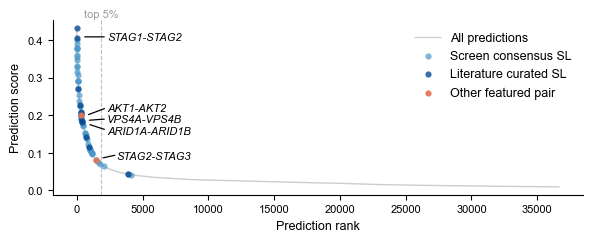

In [21]:
# Waterfall plot of all predictions, with validated and screen consensus SLs highlighted
f, ax = plt.subplots(1, 1, figsize=(6,2.5))
pal = sns.color_palette("Blues", n_colors=9)
df = all_predictions

sns.lineplot(x=df.index, y=df.prediction_score, ax=ax, alpha=1, color='#ccc', label="All predictions", zorder=1, lw=1)

sns.scatterplot(x=df[df.n_screens_SL>=2].index, y=df[df.n_screens_SL>=2].prediction_score, ax=ax, linewidth=0, s=20, alpha=0.7,
                color=pal[5], label="Screen consensus SL", zorder=2)

sns.scatterplot(x=df[df.validated_SL].index, y=df[df.validated_SL].prediction_score, ax=ax, linewidth=0, s=20, alpha=0.8,
                color=pal[8], label="Literature curated SL", zorder=3)

example_df = all_predictions[(all_predictions.A1=='STAG2') | ((all_predictions.A1=='AKT1') & (all_predictions.A2=='AKT2'))]
sns.scatterplot(x=example_df.index, y=example_df.prediction_score, ax=ax, linewidth=0, s=20, alpha=0.95,
                color='#e7745b', label="Other featured pair", zorder=4)

ax.set_ylabel('Prediction score'); ax.set_xlabel('Prediction rank')

# Draw line to show top 5%
ax.axvline(int(0.05*df.shape[0]), linestyle='--', color='silver', zorder=1, lw=0.8)
ax.text(int(0.05*df.shape[0]), 0.46, 'top 5%', fontsize=8, color='#999', ha='center')
plt.tight_layout()

# Paralog pair annotations: pair:[text_coords, line_start_coords, line_end_coords]
annots = {'STAG1-STAG2':[(2300, 0.398), (400, 0.408), (2300, 0.408)],
          'AKT1-AKT2': [(2300, 0.21), (700, 0.199), (2300, 0.22)],
          'VPS4A-VPS4B': [(2300, 0.18), (750, 0.186), (2300, 0.19)],
          'ARID1A-ARID1B': [(2300, 0.15), (800, 0.177), (2300, 0.16)],
          'STAG2-STAG3': [(3000, 0.082), (1800, 0.085), (3100, 0.095)]}
for key, val in annots.items():
    ax.text(val[0][0], val[0][1], key, fontsize=8, fontstyle="italic")
    ax.annotate("", xy=val[1], xycoords='data', xytext=val[2], textcoords='data', arrowprops=dict(arrowstyle="-", lw=0.9))

f.savefig("../figures/for_paper/waterfall_plot_full.svg", bbox_inches="tight", dpi=300)

In [22]:
print('N validated SLs in top 5%%: %d/%d' %
      (all_predictions[all_predictions.validated_SL & (all_predictions.prediction_percentile<=5)].shape[0],
      all_predictions[all_predictions.validated_SL].shape[0]))

N validated SLs in top 5%: 11/12


In [23]:
print('N screen consensus SLs in top 5%%: %d/%d' %
      (all_predictions[(all_predictions.n_screens_SL>=2) & (all_predictions.prediction_percentile<=5)].shape[0],
      all_predictions[(all_predictions.n_screens_SL>=2)].shape[0]))

N screen consensus SLs in top 5%: 47/50


In [24]:
def print_pair_rank(pair):
    print('%s is in top %.1f%%' % 
          (pair, all_predictions[all_predictions.sorted_gene_pair==pair].prediction_percentile.values[0]))
    
print_pair_rank('UBB_UBC')
print_pair_rank('RAB1A_RAB1B')
print_pair_rank('ASF1A_ASF1B')
print_pair_rank('COPS7A_COPS7B')

UBB_UBC is in top 2.6%
RAB1A_RAB1B is in top 0.6%
ASF1A_ASF1B is in top 0.1%
COPS7A_COPS7B is in top 1.2%
